https://blog.jetbrains.com/blog/2020/09/29/intelligent-code-art/

In [ ]:
! pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


# Image rendering process
Technically, our rendering engine consists of four parts: 
* Image renderer; 
* Video renderer that that produces looped animations based on already created images;
* Image Mixer - subsystem for evolving randomly generated images into more beatiful ones using genetic algorithms;
* Image recommendation engine, which (combined with Image Mixer) generates random images based on previous users' selections.

Besides that, there's a lot of small pre- and postprocessing modules allowing to do such things as dithering, antialiasing, color correction, rescaling, offset, etc.
However, these four are essential parts of the generator. Let's see how they work!

## Image rendering
Images that produces our generator are essentially landscapes of (fairly simple) feed-forward neural networks' mapping functions! Although there's a couple of tricks that make them more beautiful, most of them are based on what exact data we are passing to our networks. Actually, there's 5 float inputs corresponding to the each pixel in the image:
* `x_pos` - this one is linearly proportional to the coordinate of the current pixel over X axis of the image (exact values depend on other image generation parameters that are out of scope of this demo);
* `y_pos` - the same as the previous one but corresponds to Y axis;
* `alpha` - this one has some constant value across all the pixels in the image and used by the animation engine;
* `beta` - the same as the previous one
* `f` - this one allows to apply some general patterns to images by mapping some functions to `x_pos` and `y_pos` $f = F(x\_pos, y\_pos)$. For example, $f = \sqrt{x\_pos^{2} + y\_pos^{2}}$ produces some circular-shape patterns.

In [ ]:
# Let's define some constants that we'll need for image generation
x_resolution = 1920
y_resolution = 1080
alpha = 0.5
beta = 0.5

In [ ]:
import numpy as np

In [ ]:
# Now let's fill x_pos and y_pos with [-1, 1] values
x_pos = np.linspace(-1, 1, x_resolution)
y_pos = np.linspace(-1, 1, y_resolution)

In [ ]:
print(x_pos)
print(y_pos)

[-1.         -0.99895779 -0.99791558 ...  0.99791558  0.99895779
  1.        ]
[-1.         -0.99814643 -0.99629286 ...  0.99629286  0.99814643
  1.        ]


In [ ]:
# Now let's combine them into a x_resolution-by-y_resolution-sized grid
# In our particular case that means that we simply repeat each column and row 
# by x_resolution and y_resolution times correspondingly
x_pos, y_pos = np.meshgrid(x_pos, y_pos)
# Result is reshaped so it will be more convenient to concatenate later
x_pos = x_pos.reshape(-1, 1)
y_pos = y_pos.reshape(-1, 1)

In [ ]:
print(x_pos)
print(y_pos)

[[-1.        ]
 [-0.99895779]
 [-0.99791558]
 ...
 [ 0.99791558]
 [ 0.99895779]
 [ 1.        ]]
[[-1.]
 [-1.]
 [-1.]
 ...
 [ 1.]
 [ 1.]
 [ 1.]]


In [ ]:
# Now when we have x_pos and y_pos, let's compute example of F:
f = np.sqrt(x_pos ** 2 + y_pos ** 2)

In [ ]:
print(f)

[[1.41421356]
 [1.4134768 ]
 [1.41274042]
 ...
 [1.41274042]
 [1.4134768 ]
 [1.41421356]]


In [ ]:
# Finally, we need to repeat our alpha and beta
alpha_filled = np.full((x_pos.shape[0], 1), alpha)
beta_filled = np.full((x_pos.shape[0], 1), beta)

In [ ]:
input_space = np.concatenate(np.array((x_pos, y_pos, alpha_filled, beta_filled, f)), axis=1)

In [ ]:
# Our resulting array is flattened across its dimensions 
# so it would be more convenient to perform batch inference in the future
print(input_space.shape)

(2073600, 5)


In [ ]:
# Now let's define a simple model building method
import tensorflow as tf 
from tensorflow import keras

In [ ]:
def build_densenet(width=4, depth=4, variance=400, activation='tanh', seed=42):
    assert width > 0 and depth > 0 and variance > 0
    tf.random.set_seed(seed)
    input_shape = (5,)  # number of parameters in input space defined above
    initializer = keras.initializers.VarianceScaling(scale=variance,
                                                     mode='fan_in',
                                                     distribution='normal',
                                                     seed=seed)
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(depth):
        y = keras.layers.Dense(width, kernel_initializer=initializer, activation=activation)(x)
        x = keras.layers.Concatenate()([x, y])
    bottleneck_initializer = keras.initializers.GlorotNormal(seed)
    bottleneck = keras.layers.Dense(3,  # The number of channels in RGB image
                                    activation='tanh',
                                    kernel_initializer=bottleneck_initializer)(x)
    model = keras.Model(inputs=inputs, outputs=bottleneck)
    return model

In [ ]:
example_model = build_densenet()
example_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 4)            24          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 9)            0           input_1[0][0]                    
                                                                 dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4)            40          concatenate[0][0]     

In [ ]:
# Some images could contain gradient bandings. Let's add a grain effect:
def dither_image(img: np.ndarray, noise_factor: float = 1):
    img += (np.random.random(img.shape) - 0.5) * (noise_factor / 256)
    img[img < 0] = 0
    img[img > 1] = 1
    return img

In [ ]:
# Finally, let's write a method for inferencing the network:
def render_image(model, input_space, out_shape):
    pred = model.predict(input_space, batch_size=65536)
    # Normalizing the predictions
    pred_normed = (pred - pred.min(0)) / (pred.ptp(0) + 1e-10)
    img_arr = pred_normed.reshape(*out_shape)
    img = dither_image(img_arr, noise_factor=2)
    img_arr = (img_arr * 255).astype(np.uint8)
    return img_arr

In [ ]:
from matplotlib import pyplot as plt

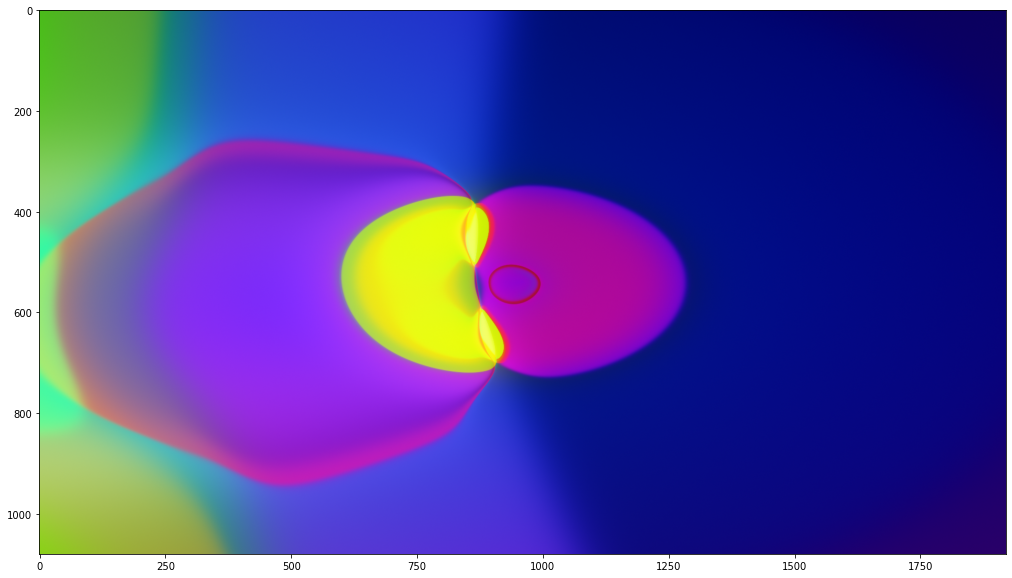

In [ ]:
example_image = render_image(example_model, input_space, (y_resolution, x_resolution, 3))
plt.figure(figsize=(19, 10))
plt.imshow(example_image)
plt.show()

## Color correction
Now, when we get our image generated, let's recolor it to match Datalore logo palette! Coloring consists of three steps:
* Convert image to grayscale;
* Apply color component transform (see [Mozilla SVG specs](https://developer.mozilla.org/en-US/docs/Web/SVG/Element/feComponentTransfer) for the reference);
* Apply color matrix transform ([reference](https://developer.mozilla.org/en-US/docs/Web/SVG/Element/feColorMatrix)).

Usually they're done in browser, but we could reimplement them in Python:

In [ ]:
color_params = {
    'grayscale_matrix': [0.3, 0.3, 0.3, 0.0, 0.3, 0.3, 0.3, 0.0, 0.3, 0.3, 0.3, 0.0],
    'red_component': [0, 0.11568627450980393, 0.3254901960784314, 0.23137254901960785, 0.4196078431372549, 0.027450980392156862, 1],
    'green_component': [0, 0.4588235294117647, 0.6294117647058823, 0.9176470588235294, 0.3411764705882353, 0.7647058823529411, 1],
    'blue_component': [0, 0.19215686274509805, 0.692156862745098, 0.3843137254901961, 1, 0.9490196078431372, 1],
    'color_matrix': [1.3935000000000002, -0.35750000000000004, -0.03599999999999999, 0, 
                     -0.10650000000000001, 1.1425, -0.03599999999999999, 0,
                     -0.10650000000000001, -0.35750000000000004, 1.4640000000000002, 0]
                     }

In [ ]:
def component_transfer(grayscale: np.ndarray, component: list):
    n = len(component) - 1

    def precompute_transfer(x):
        if x == 1:
            return component[-1]
        k = int(x * n)
        x_new = component[k] + (x - k / n) * n * (component[k + 1] - component[k])
        return round(x_new * 255)

    transfer_lookup = {x: precompute_transfer(x / 255) for x in range(256)}
    gradientmap = np.vectorize(transfer_lookup.get)(grayscale)
    return gradientmap

In [ ]:
from PIL import Image, ImageChops

In [ ]:
def render_colored_image(model, input_space, out_shape, color_params):
    source_img_arr = render_image(model, input_space, out_shape)
    source_img = Image.fromarray(source_img_arr)
    grayscale = source_img.convert('RGB', color_params['grayscale_matrix'])
    grayscale_arr = np.array(grayscale)
    gradientmap_arr = np.zeros(grayscale_arr.shape, dtype=np.uint)
    gradientmap_arr[:, :, 0] = component_transfer(grayscale_arr[:, :, 0], color_params['red_component'])
    gradientmap_arr[:, :, 1] = component_transfer(grayscale_arr[:, :, 1], color_params['green_component'])
    gradientmap_arr[:, :, 2] = component_transfer(grayscale_arr[:, :, 2], color_params['blue_component'])
    gradientmap = Image.fromarray(gradientmap_arr.astype(np.uint8))
    blended = ImageChops.multiply(gradientmap, grayscale)
    result_img = blended.convert('RGB', color_params['color_matrix'])
    return result_img

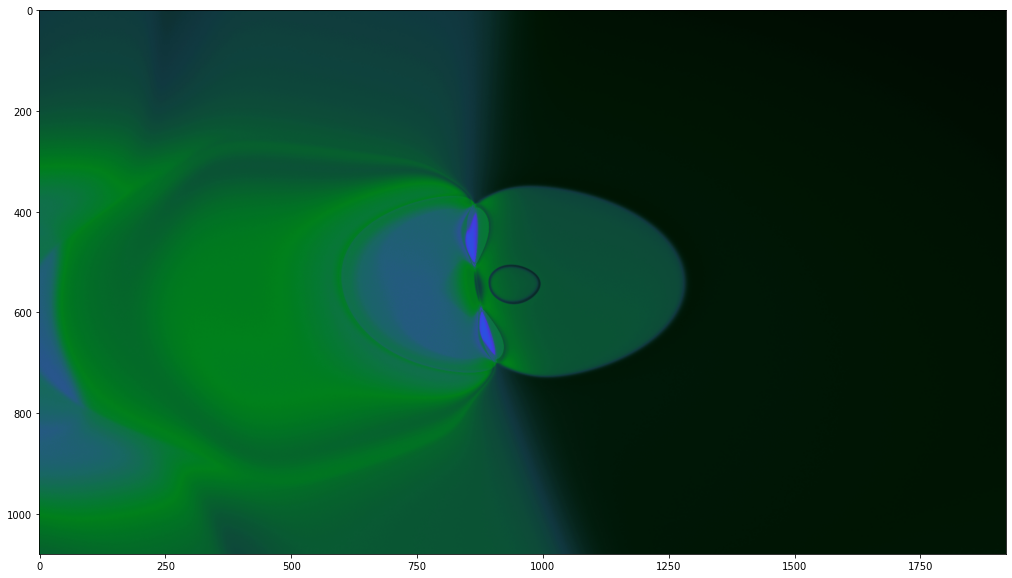

In [ ]:
colored_img = render_colored_image(example_model, input_space, (y_resolution, x_resolution, 3), color_params)
plt.figure(figsize=(19, 10))
plt.imshow(colored_img)
plt.show()

## Video generation
In the previous image generation demo we have used constant `alpha` and `beta` values. Now it's time to animate them!

In [ ]:
import math
def animate_alpha_beta(init_alpha=0.5, init_beta = 0.5):
    radius = (alpha ** 2 + beta ** 2) ** 0.5
    angle = math.atan2(beta, alpha)
    num_frames = 10
    alphas = [radius * math.cos(angle + i * math.pi / num_frames * 2) for i in range(num_frames)]
    betas = [radius * math.sin(angle + i * math.pi / num_frames * 2) for i in range(num_frames)]
    return alphas, betas

What we did here is essentially generated a circle starting at [alpha; beta]:

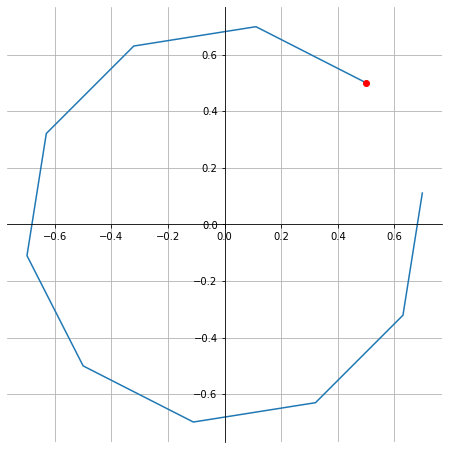

In [ ]:
sample_alphas, sample_betas = animate_alpha_beta()
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(sample_alphas, sample_betas)
ax.plot(sample_alphas[0], sample_betas[0], 'ro')
ax.set_aspect('equal')
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()
plt.show()

In [ ]:
for a, b in zip(sample_alphas, sample_betas):
    alpha_filled_animate = np.full((x_pos.shape[0], 1), a)
    beta_filled_animate = np.full((x_pos.shape[0], 1), b)
    input_space_animate = np.concatenate(np.array((x_pos, y_pos, alpha_filled_animate, beta_filled_animate, f)), axis=1)
    example_image = render_colored_image(example_model, input_space_animate, (y_resolution, x_resolution, 3), color_params)
    plt.figure(figsize=(19, 10))
    plt.imshow(example_image)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Image Mixer
Image Mixer is the key tool for generating eye-pleasant images with little effort. It combines parameters of images that you've selected, thus producing new ones, similar to those that you've liked.
It's a simple implementation of genetic algorithm: parameters of selected images are crossing-overed, with a chance to mutate into something entirely new. Let's make a simplified version of it:

In [ ]:
import random

In [ ]:
def mix_two_images(params_1, params_2, mutated_params, mutation_chance=0.05, mutation_intensity=0.05):
    result = {}
    for param_name in params_1:
        resulting_param = random.choices(
        [random.choice([params_1[param_name], params_2[param_name]]), mutated_params[param_name],  # crossing over
         random.choice([params_1[param_name], params_2[param_name]]) * (1 + mutation_intensity),  # mutation
         random.choice([params_1[param_name], params_2[param_name]]) * (1 - mutation_intensity)],  # mutation
        weights=[1 - mutation_chance] + [mutation_chance / 3] * 3)[0]
        result[param_name] = resulting_param
    return result

In [ ]:
# params_1 stands for our first image that we've already generated
params_1 = {
    'width': 4, 
    'depth': 4, 
    'variance': 400, 
    'seed': 42
}
# params_2 stands for our another image that we supposedly liked
params_2 = {
    'width': 6, 
    'depth': 3, 
    'variance': 500, 
    'seed': 1337
}
# mutated_params are random
mutated_params = {
    'width': random.randint(1, 32), 
    'depth': random.randint(1, 32), 
    'variance': random.randint(100, 5000), 
    'seed': random.randint(1, 1000000)
}

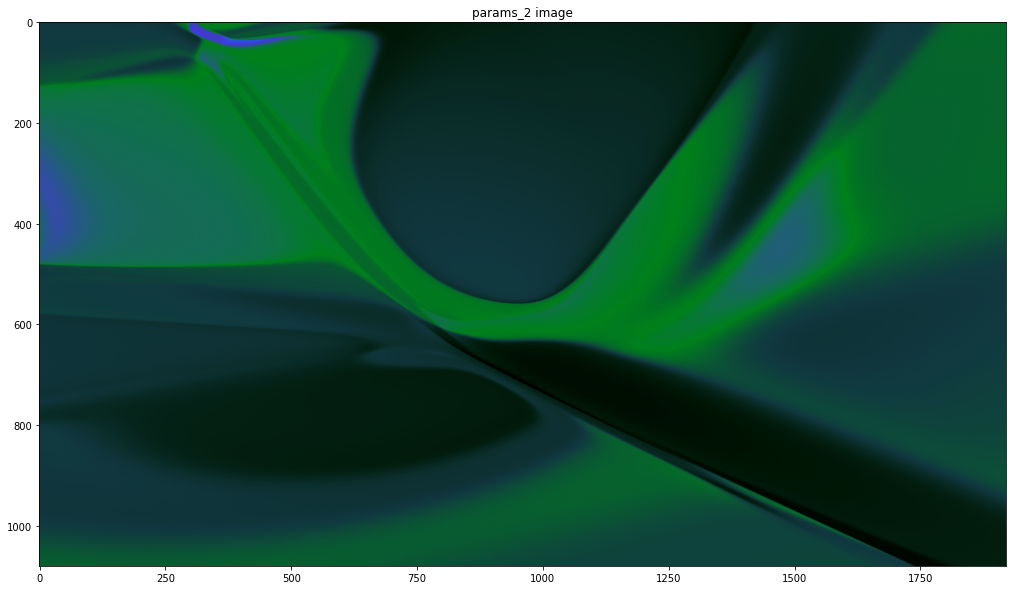

In [ ]:
params_2_model = build_densenet(**params_2)
params_2_img = render_colored_image(params_2_model, input_space, (y_resolution, x_resolution, 3), color_params)
plt.figure(figsize=(19, 10))
plt.imshow(params_2_img)
plt.title('params_2 image')
plt.show()

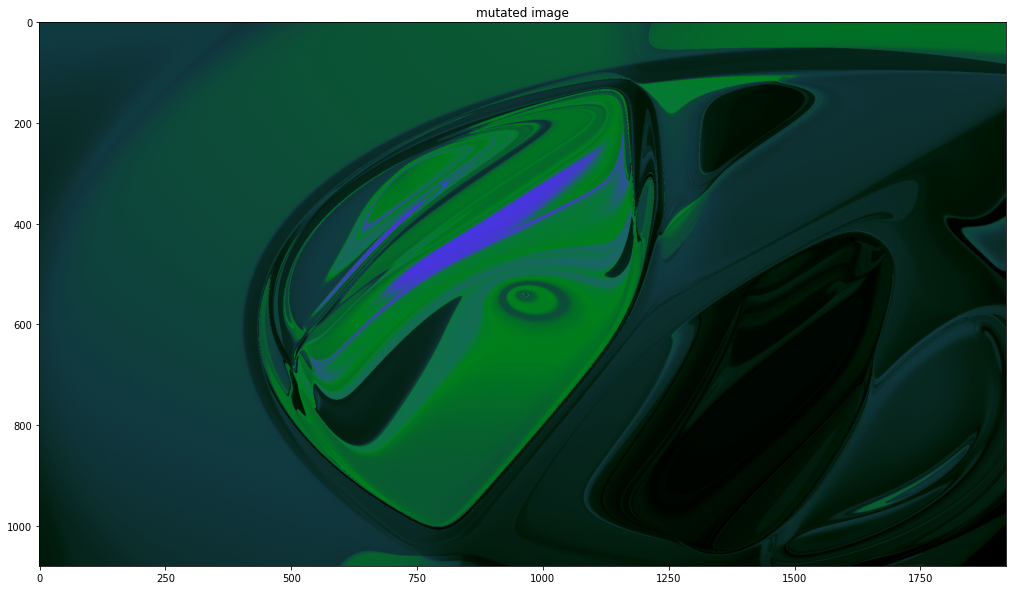

In [ ]:
mutated_model = build_densenet(**mutated_params)
mutated_img = render_colored_image(mutated_model, input_space, (y_resolution, x_resolution, 3), color_params)
plt.figure(figsize=(19, 10))
plt.imshow(mutated_img)
plt.title('mutated image')
plt.show()

In [ ]:
import json  # for pretty-printing

In [ ]:
# Let's mix 'em!
mixed_params = mix_two_images(params_1, params_2, mutated_params, mutation_chance=0.05, mutation_intensity=0.05)
print(json.dumps(mixed_params, indent=4))

{
    "width": 4,
    "depth": 3,
    "variance": 400,
    "seed": 1337
}


Feel free to play around with contents of `params_1` and `params_2`, as well as with values of `mutation_chance` and `mutation_intensity` ;)

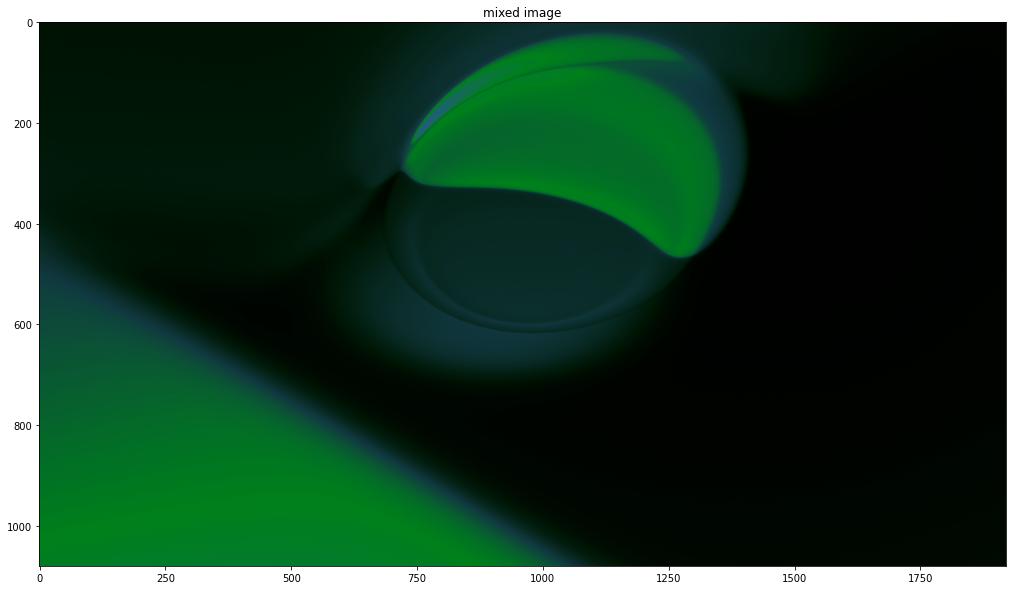

In [ ]:
mixed_model = build_densenet(**mixed_params)
mixed_img = render_colored_image(mixed_model, input_space, (y_resolution, x_resolution, 3), color_params)
plt.figure(figsize=(19, 10))
plt.imshow(mixed_img)
plt.title('mixed image')
plt.show()

## Image recommendations
Using information about which images were mixed by users - and therefore which of them could be considered beautiful - we can train a binary classification model which will predict which set of parameters could lead to a beautiful image.

**YOU NEED TO UPDATE SCIKIT-LEARN TO 0.23.1 TO PROCEED**

In [ ]:
# Downloading pre-trained model
import urllib
urllib.request.urlretrieve ("http://comp-arts-limb-images.s3.amazonaws.com/limb_demo_model.bin", "limb_demo_model.bin")

('limb_demo_model.bin', <http.client.HTTPMessage at 0x7f2f220d1470>)

In [ ]:
import pickle
from sklearn.svm import SVC
with open('limb_demo_model.bin', 'rb') as fp:
    demo_model: SVC = pickle.load(fp)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator SVC from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
def get_random_params():
    params = {
        'seed': random.randint(0, 100000000),
        'variance': random.randint(4, 4096),
        'architecture': random.choice(['perceptron', 'densenet', 'resnet',
                                    'resnet_concat', 'chain', 'plexus']),
        'activation': random.choice(['tanh', 'sigmoid', 'hard_sigmoid', 'softsign']),
        'width': random.randint(2, 32),
        'depth': random.randint(2, 32),
        'alpha': random.uniform(-1, 1),
        'beta': random.uniform(-1, 1),
    }
    return params

In [ ]:
def params_to_features(variance: float,
                       architecture: str,
                       activation: str,
                       width: int,
                       depth: int,
                       beautiful: bool = False):
    feature_vector = np.zeros((14,), np.float32)
    feature_vector[0] = variance / 4096
    feature_vector[1] = architecture == 'perceptron'
    feature_vector[2] = architecture == 'densenet'
    feature_vector[3] = architecture == 'resnet'
    feature_vector[4] = architecture == 'resnet_concat'
    feature_vector[5] = architecture == 'chain'
    feature_vector[6] = architecture == 'plexus'
    feature_vector[7] = activation == 'tanh'
    feature_vector[8] = activation == 'sigmoid'
    feature_vector[9] = activation == 'hard_sigmoid'
    feature_vector[10] = activation == 'softsign'
    feature_vector[11] = width / 64
    feature_vector[12] = depth / 64
    feature_vector[13] = beautiful
    return feature_vector

In [ ]:
def generate_params_recommendations(model: SVC):
    # Generating random parameters
    params_batch = [get_random_params() for _ in range(100)]
    params_batch_features = [params_to_features(params['variance'],
                                                params['architecture'],
                                                params['activation'],
                                                params['width'],
                                                params['depth'])
                             for params in params_batch]
    # Removing unused feature colon
    params_batch_features = [x[:-1] for x in params_batch_features]
    # Making beautifulness prediction
    params_scores = model.predict_proba(params_batch_features)
    params_scores = [x[1] for x in params_scores]
    # Sorting our random params sets and picking the first five of them
    best_params = sorted(zip(params_batch, params_scores),
                         key=lambda x: x[1],
                         reverse=True)
    best_params = [x[0] for x in best_params][:5]
    return best_params

In [ ]:
best_params = generate_params_recommendations(demo_model)
print(json.dumps(best_params, indent=4))

[
    {
        "seed": 95138463,
        "variance": 1486,
        "architecture": "perceptron",
        "activation": "sigmoid",
        "width": 23,
        "depth": 2,
        "alpha": 0.9682962147080405,
        "beta": -0.32924417246058457
    },
    {
        "seed": 94515251,
        "variance": 3844,
        "architecture": "densenet",
        "activation": "tanh",
        "width": 24,
        "depth": 20,
        "alpha": -0.34389117699380356,
        "beta": -0.7426114890082489
    },
    {
        "seed": 77521628,
        "variance": 2670,
        "architecture": "plexus",
        "activation": "sigmoid",
        "width": 2,
        "depth": 5,
        "alpha": 0.9948211312065631,
        "beta": -0.6911735210067833
    },
    {
        "seed": 5797199,
        "variance": 2265,
        "architecture": "plexus",
        "activation": "sigmoid",
        "width": 5,
        "depth": 6,
        "alpha": -0.319013709390223,
        "beta": 0.36560434476475323
    },
    {
    